# Sector Rotation strategy with momentum
## Use Index of representative asset classes
#### Market Index ETF, sector etf, bond etf are included
#### Result is driven from 2010 to 2021 market data

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [15]:
start_date='2006-01-01'
end_date='2022-09-01'
cost=0.001

In [16]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [17]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [18]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation

### Load Data of each asset classes
##### Use representative ETF to model strategy
##### Data should be in yld format [rows : Dates, Columns : Asset Classes, yld = log(currnet_period_price/previous_period_price]

In [31]:
class SectorRotation(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
    

        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)
        # return_df = return_df.fillna(1)
        # self.return_df_dd = return_df

        target = {} 
        result = self.sector_momentum(return_df)
        for ticker in return_df.columns:
            target[ticker] = result.loc[date, ticker]

        # target = {}
        # for i in range(len(custom_universe)):
        #     target[custom_universe[i]] = result.x[i]

        return target

    def get_momentum(self, yld_df):
        """
        calculate momentum of sectors. use 12 month, 6 month, 3 month momentum to bit market
        input
        yiled_df : dataframe with weekly yield of asset classes

        returns : momentum in pandas dataframe format. momentum of each asset classes for give date
        """
        momentum = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)

        # for ticker in momentum.columns:
        #     try:
        #         momentum.loc[date,ticker] = np.log(return_df.loc[date,ticker] - return_df.loc[date_12_month_lag,ticker])
        #     except:
        #         momentum.loc[date,ticker] = 0
        
        windows = 250
        for ticker in yld_df.columns:
            i = 0 
            for date in yld_df.index:
                # 250 days before = 1 year  before
                if i > windows :
                    # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                    momentum.loc[date, ticker] = yld_df[ticker].iloc[i] / yld_df[ticker].iloc[i - windows] - 1
                else:
                    momentum.loc[date, ticker] = 0
                i = i + 1

        momentum = momentum.replace([np.inf], 1000)
        momentum = momentum.replace([-np.inf], -1000)
        momentum = momentum.replace([np.nan], 0)

        return momentum

    def select_sector(self, yld_df):
        """
        select top 5 sectors with highest momentum score
        returns: selected_tickers in list format. list with top 5 momentum in given period`
        """
        # inherit previous method and run
        momentum_df = self.get_momentum(yld_df)
        selected_momentum = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
            index=momentum_df.index
        )
        selected_ticker = pd.DataFrame(
            columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
            index=momentum_df.index
        )
        for date in momentum_df.index:
            sorted_momentum = momentum_df.loc[date].sort_values(ascending=False)
            for i in range(len(selected_momentum.columns)):
                selected_momentum.loc[date,f'momentum_{i+1}'] = sorted_momentum[i]
                selected_ticker.loc[date,f'momentum_{i+1}'] = sorted_momentum.index[i]
        return selected_ticker

    def sector_momentum(self, yld_df):
        """
        returns : market portfolio in pandas dataframe format.
        """
        # inherit previous method and run
        # select_sector method returns tickers
        mom_ticker_df = self.select_sector(yld_df)
        # print(mom_ticker_df)
        # input(1)
        mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
        for date in yld_df.index:
            selected = mom_ticker_df.loc[date].tolist()
            for sel in selected:
                mp_table.loc[date, sel] = 1/len(selected)
        mp_table = mp_table.fillna(0)
        return mp_table


In [32]:
custom_universe =[
    "XLB",  # The Materials Select Sector SPDR® Fund                1998-12-16
    "XLE",  # The Energy Select Sector SPDR® Fund                   1998-12-22
    "XLF",  # The Financial Select Sector SPDR® Fund                1998-12-22
    "XLI",  # The Industrial Select Sector SPDR® Fund               1998-12-22
    "XLK",  # The Technology Select Sector SPDR® Fund               1998-12-22
    "XME",  # SPDR® S&P® Metals & Mining ETF                        2006-06-23
    "XLP",  # The Consumer Staples Select Sector SPDR® Fund         1998-12-22
    "XLY",  # The Consumer Discretionary Select Sector SPDR® Fund   1998-12-22
    "XLU",  # The Utilities Select Sector SPDR® Fund                1998-12-22
    "XLV",  # The Health Care Select Sector SPDR® Fund              1998-12-22
    "XPH",  # SPDR® S&P® Pharmaceuticals ETF                        2006-06-22
    "XBI",  # SPDR® S&P® Biotech ETF                                2006-02-06
    ]

In [33]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = SectorRotation(engine.cache)
engine.run_backtest(target_generator=rp, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 11.64 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-09-01 00:00:00
2005-12-30 00:00:00
{'XLK': 0.0, 'XLV': 0.2, 'XLB': 0.0, 'XLP': 0.2, 'XLU': 0.2, 'XLY': 0.2, 'XLE': 0.0, 'SPY': 0.0, 'XLF': 0.2, 'XLI': 0}
2006-01-31 00:00:00 00:00:00 / total_asset:0.999 / time elapsed:1.2 ===
{'XLK': 0.0, 'XLV': 0.2, 'XLB': 0.2, 'XLU': 0.2, 'XLP': 0.2, 'XLY': 0, 'XLE': 0.2, 'SPY': 0.0, 'XLF': 0, 'XLI': 0.0}
2006-02-28 00:00:00 00:00:00 / total_asset:0.987 / time elapsed:1.8 ===
{'XLK': 0.2, 'XLV': 0.0, 'XBI': 0.0, 'XLB': 0.2, 'XLP': 0.2, 'XLU': 0.2, 'XLY': 0, 'XLE': 0.0, 'SPY': 0.2, 'XLF': 0, 'XLI': 0.0}
2006-03-31 00:00:00 00:00:00 / total_asset:0.993 / time elapsed:2.4 ===
{'XLK': 0.0, 'XLV': 0.0, 'XBI': 0.2, 'XLB': 0.0, 'XLP': 0.0, 'XLU': 0.0, 'XLY': 0, 'XLE': 0.2, 'SPY': 0.2, 'XLF': 0.2, 'XLI': 0.2}
2006-04-28 00:00:00 00:00:00 / total_asset:1.014 / time elapsed:3.1 ===
{'XLK': 0.2, 'XLV': 0.2, 'XBI': 0.0, 'XLB': 0.0, 'XLP': 0.0, 'XLU': 0.2, 'XLY': 0.0, 'XLE': 0.2,

#### Definining Momentum in Sector Rotation Strategy
#### Select Sector ETF if following conditions satisfied
#### 1. Choose sector which show greater 12 month return (5 sectors)
#### 2. Sector should show greater 12 month return than S&P500 index
#### Choose up to five sectors and distribute equal weight
#### If fails, replace it with safety fixed income (SHY)

### by using 12 month momentum

In [60]:
def get_momentum(yld_df):
    """
    calculate momentum of sectors. use 12 month, 6 month, 3 month momentum to bit market
    input
    yiled_df : dataframe with weekly yield of asset classes

    returns : momentum in pandas dataframe format. momentum of each asset classes for give date
    """
    momentum = pd.DataFrame(columns = yld_df.columns, index = yld_df.index)

    for asset in  yld_df.columns:
        i = 0
        for date in yld_df.index:
            # 52 weeks per year = 12 month
            if i > windows :
                # first 12 month data (52 data points) cannot be used since 12 month lagged returns is required
                momentum.loc[date, asset] = yld_df[asset].iloc[i] / yld_df[asset].iloc[i - windows] - 1
            else:
                momentum.loc[date, asset] = 0
            i = i + 1
    momentum = momentum.replace([np.inf], 1000)
    momentum = momentum.replace([-np.inf], -1000)
    momentum = momentum.replace([np.nan], 0)
    return momentum

def select_sector(yld_df):
    """
    select top 5 sectors with highest momentum score
    returns: selected_tickers in list format. list with top 5 momentum in given period`
    """
    # inherit previous method and run
    momentum_df = get_momentum(yld_df)
    selected_momentum = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
        index=momentum_df.index
    )
    selected_ticker = pd.DataFrame(
        columns=['momentum_1','momentum_2','momentum_3','momentum_4','momentum_5'],
        index=momentum_df.index
    )

    for date in momentum_df.index:
        sorted_momentum = momentum_df.loc[date].sort_values(ascending=False)
        for i in range(len(selected_momentum.columns)):
            selected_momentum.loc[date,f'momentum_{i+1}'] = sorted_momentum[i]
            selected_ticker.loc[date,f'momentum_{i+1}'] = sorted_momentum.index[i]

    return selected_ticker


def sector_momentum(yld_df):
    """
    returns : market portfolio in pandas dataframe format.
    """
    # inherit previous method and run
    # select_sector method returns tickers
    mom_ticker_df = select_sector(yld_df)
    mp_table = pd.DataFrame(columns=yld_df.columns, index=yld_df.index)
    for date in yld_df.index:
        selected = mom_ticker_df.loc[date].tolist()
        for sel in selected:
            mp_table.loc[date, sel] = 1/5
    mp_table = mp_table.fillna(0)

    return mp_table

def trim_data(yld_df, mp_table, benchmark_yield_df):
    """
    since momentum strategy uses 12 month lagged momentum, first 12 month data cannot be used
    return : yld_df, mp_table, bm_yld in dataframe format
    """
    yld_df = yld_df.iloc[windows + 1:]
    mp_table = mp_table.iloc[windows + 1:]
    benchmark_yield_df = benchmark_yield_df.iloc[windows + 1:]
    return yld_df, mp_table, benchmark_yield_df

In [61]:
mp_table_result = sector_momentum(yield_df)
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)
mp_table_result

,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI
Date,,,,,,,,,,,,
2008-03-31,0.2,0.0,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2
2008-04-30,0.0,0.0,0.0,0.2,0.2,0.0,0.2,0.2,0.0,0.0,0.0,0.2
2008-05-31,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0
2008-06-30,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.2
2008-07-31,0.2,0.2,0.2,0.0,0.0,0.0,0.2,0.2,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
2021-12-31,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.2,0.0,0.0,0.0
2022-01-31,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0


In [62]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=sector_momentum, yld_df=yield_df,
    bm_strategy=sp500_buy_hold_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy

,strategy_return,benchmark_return,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,SUM
Date,,,,,,,,,,,,,,,
2008-03-31,0,0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-04-30,0.024507,0.030667,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-05-31,0.039218,0.029541,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-06-30,0.004213,-0.01509,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2008-07-31,-0.079686,-0.070736,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.066927,0.059617,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,1.0
2021-12-31,-0.057063,-0.02089,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.2,0.0,0.0,0.0,1.0
2022-01-31,0.074491,0.064285,0.2,0.0,0.2,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.0,0.0,1.0


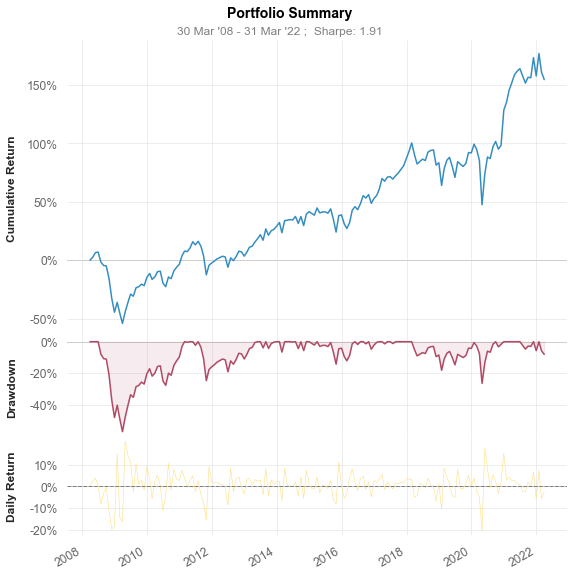

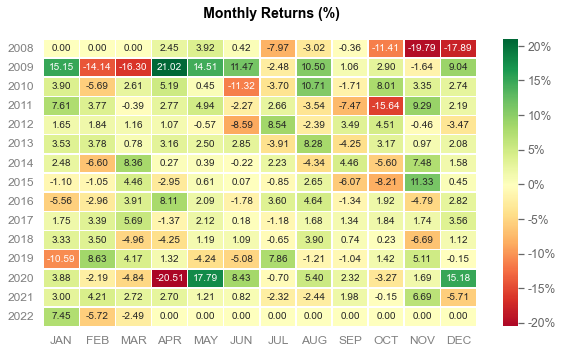

In [63]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

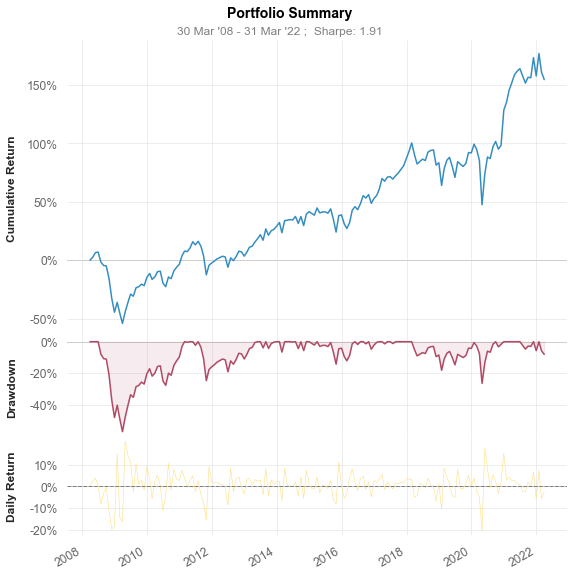

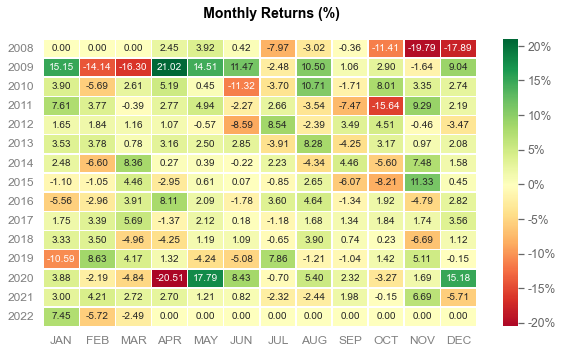

In [64]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2008-03-31  2008-03-31
End Period                 2022-03-31  2022-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          154.51%     326.02%
CAGR﹪                     6.9%        10.9%

Sharpe                     1.92        3.01
Smart Sharpe               1.88        2.97
Sortino                    2.79        4.37
Smart Sortino              2.74        4.29
Sortino/√2                 1.97        3.09
Smart Sortino/√2           1.94        3.04
Omega                      1.4         1.4

Max Drawdown               -57.06%     -48.93%
Longest DD Days            942         1034
Volatility (ann.)          98.65%      83.87%
R^2                        0.89        0.89
Calmar                     0.12        0.22
Skew                       -0.41       -0.78
Kurtosis                   2.27        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-07-31,2009-03-31,2011-02-28,942,-57.058619,-48.693257
2,2018-03-31,2020-04-30,2020-09-30,914,-26.416301,-18.153477
3,2011-08-31,2011-10-31,2013-05-31,639,-24.706571,-19.112032
4,2015-04-30,2015-10-31,2016-05-31,397,-14.252407,-12.124935
5,2022-02-28,2022-03-31,2022-03-31,31,-8.062367,-5.716235


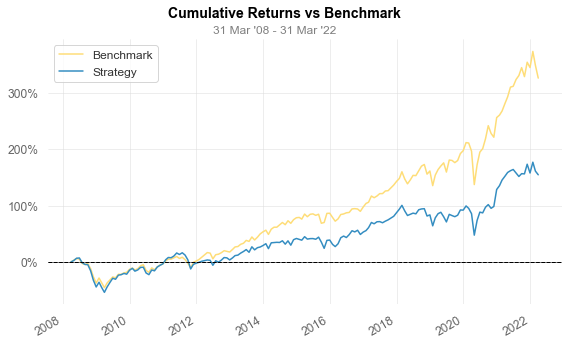

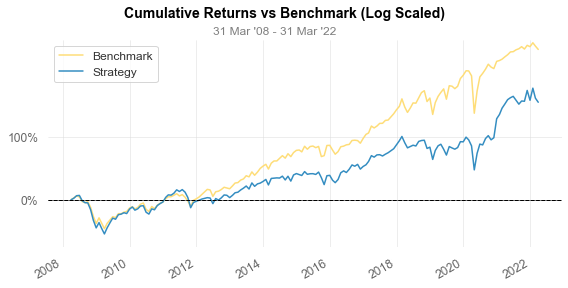

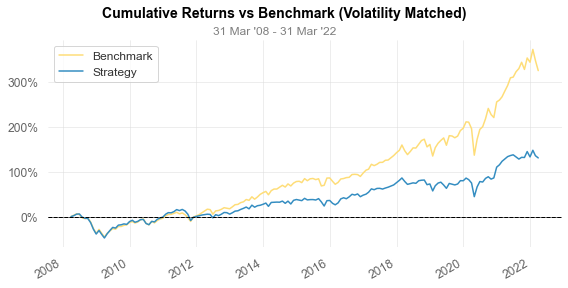

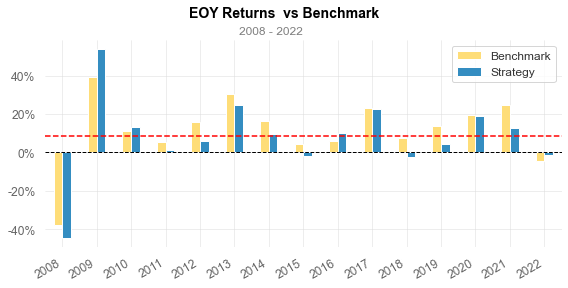

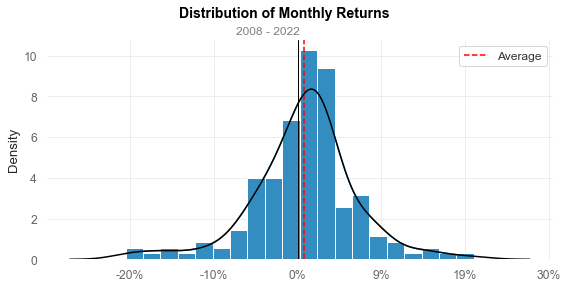

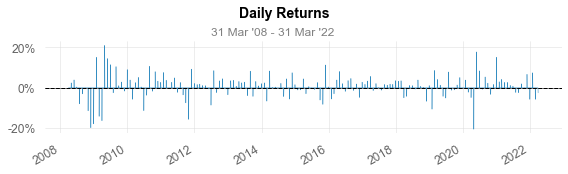

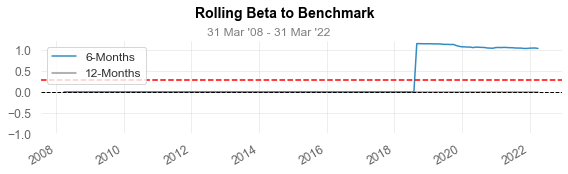

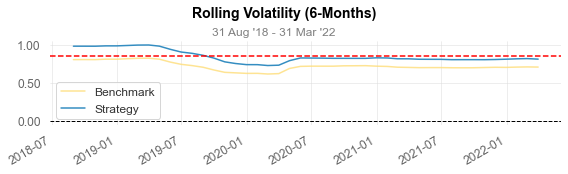

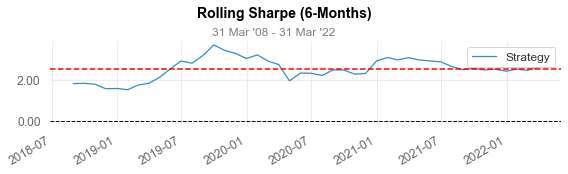

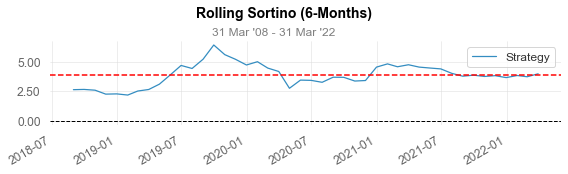

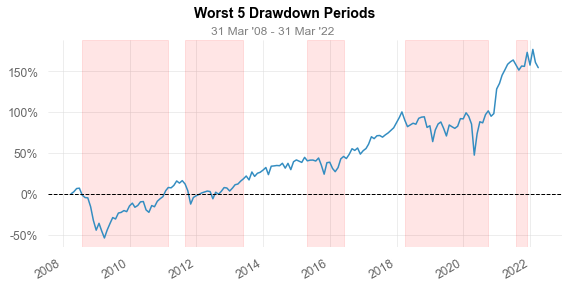

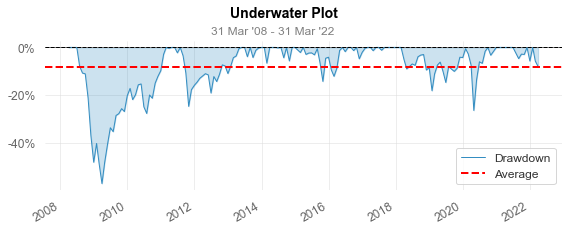

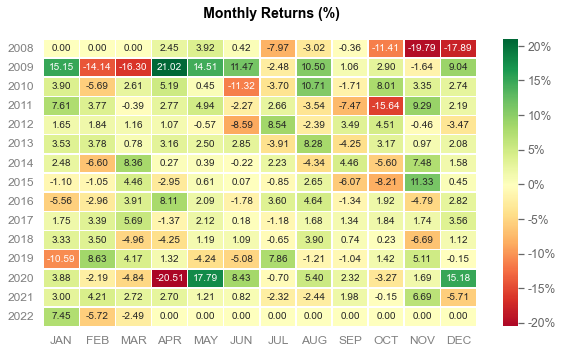

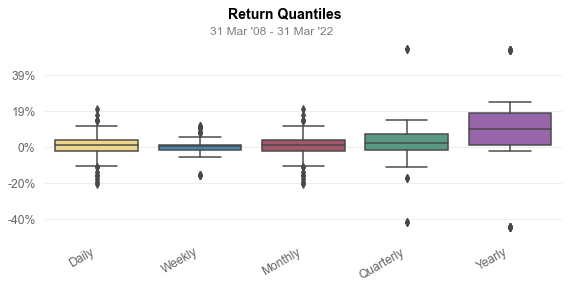

In [65]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)

### by using 3 month momentum

In [72]:
windows = 6

In [73]:
mp_table_result = sector_momentum(yield_df)
yield_df, mp_table_result, benchmark_yield_df = trim_data(yield_df, mp_table_result, benchmark_yield_df)
mp_table_result

,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI
Date,,,,,,,,,,,,
2009-02-28,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.0
2009-03-31,0.2,0.2,0.0,0.0,0.0,0.2,0.0,0.2,0.0,0.0,0.0,0.2
2009-04-30,0.0,0.2,0.0,0.2,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.0
2009-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.2,0.2,0.2
2009-06-30,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.2,0.0,0.0,0.0,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.0,0.2,0.0,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0
2021-12-31,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.2
2022-01-31,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.2,0.0


In [74]:
rebal_strategy = momentum_rebalance_strategy(
    strategy=sector_momentum, yld_df=yield_df,
    bm_strategy=sp500_buy_hold_strategy, bm_yld_df=benchmark_yield_df,
    lookback_period=0
)
rebal_strategy

,strategy_return,benchmark_return,XLB,XLE,XLF,XLI,XLK,XME,XLP,XLY,XLU,XLV,XPH,XBI,SUM
Date,,,,,,,,,,,,,,,
2009-02-28,0,0,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-03-31,-0.163046,-0.144221,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-04-30,0.210233,0.155806,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-05-31,0.131414,0.08442,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2009-06-30,0.098078,0.078302,0.2,0.2,0.2,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,0.064264,0.059617,0.0,0.2,0.0,0.2,0.2,0.0,0.0,0.2,0.2,0.0,0.0,0.0,1.0
2021-12-31,-0.026948,-0.02089,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.0,0.2,1.0
2022-01-31,0.063272,0.064285,0.0,0.2,0.0,0.0,0.2,0.0,0.0,0.2,0.0,0.2,0.2,0.0,1.0


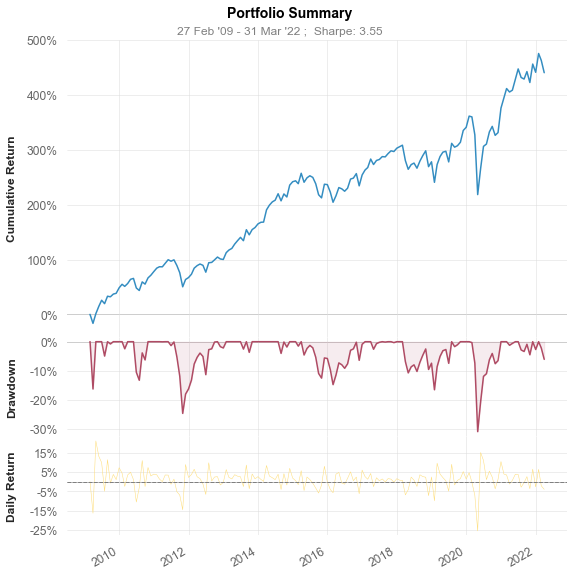

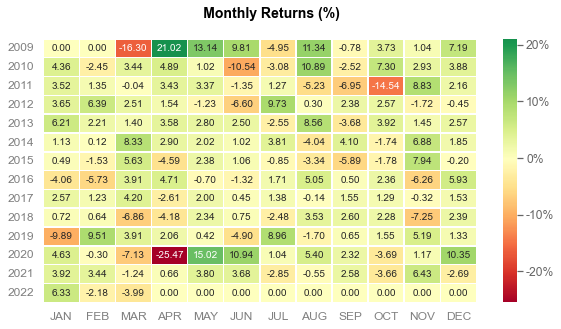

In [75]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

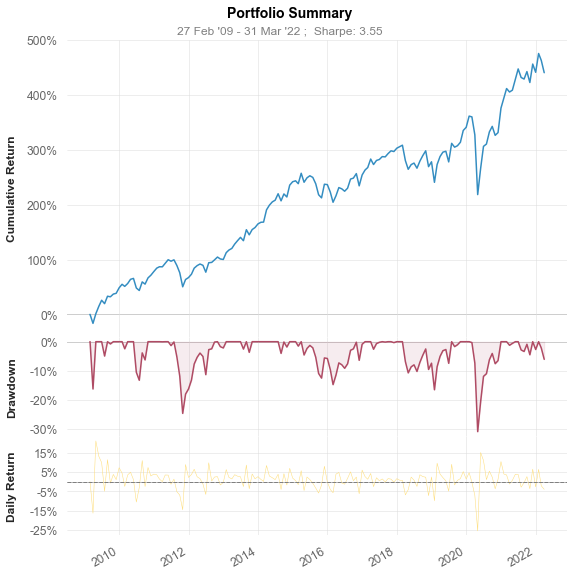

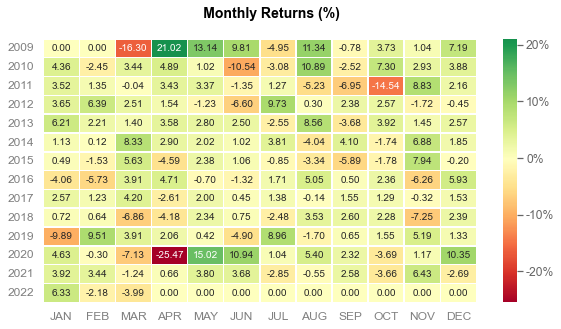

In [76]:
quantstats.reports.plots(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'], mode='basic')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2009-02-28  2009-02-28
End Period                 2022-03-31  2022-03-31
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          440.45%     572.77%
CAGR﹪                     13.75%      15.67%

Sharpe                     3.56        4.41
Smart Sharpe               3.23        4.01
Sortino                    5.49        6.89
Smart Sortino              4.99        6.26
Sortino/√2                 3.88        4.87
Smart Sortino/√2           3.53        4.42
Omega                      1.88        1.88

Max Drawdown               -31.0%      -23.89%
Longest DD Days            642         275
Volatility (ann.)          86.78%      75.92%
R^2                        0.88        0.88
Calmar                     0.44        0.66
Skew                       -0.65       -0.71
Kurtosis                   4.55       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-29,2020-04-30,2020-12-31,306,-30.997409,-20.636355
2,2011-06-30,2011-10-31,2012-10-31,489,-24.714616,-18.065681
3,2018-03-31,2019-01-31,2019-07-31,487,-16.568242,-10.751137
4,2009-03-31,2009-03-31,2009-04-30,30,-16.304605,0.000000
5,2015-04-30,2016-02-29,2017-01-31,642,-14.798195,-12.546386


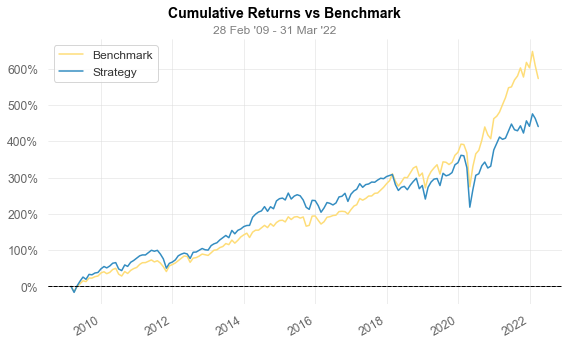

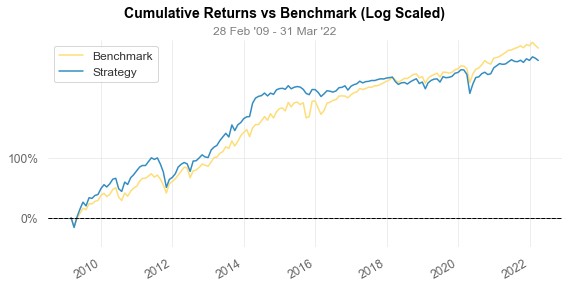

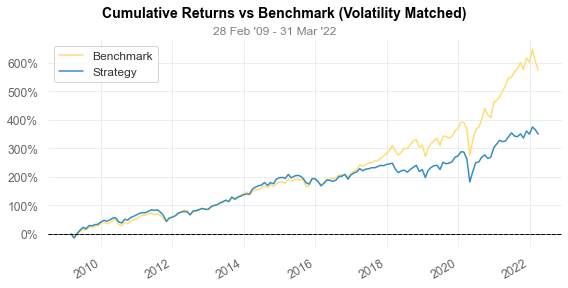

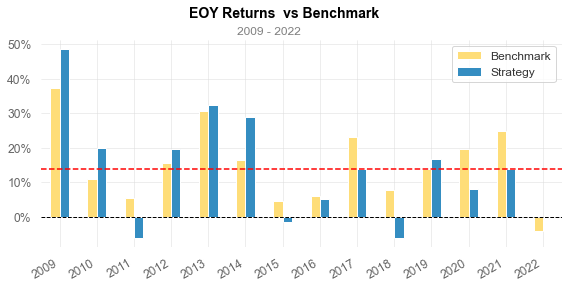

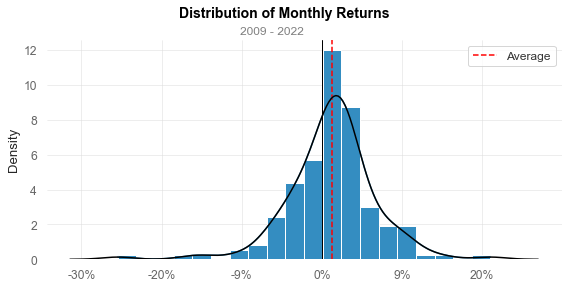

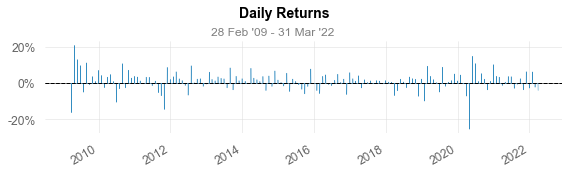

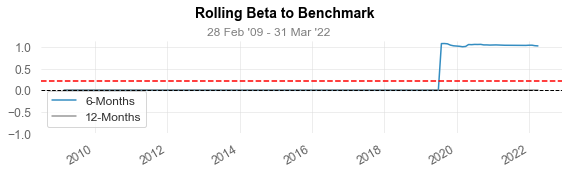

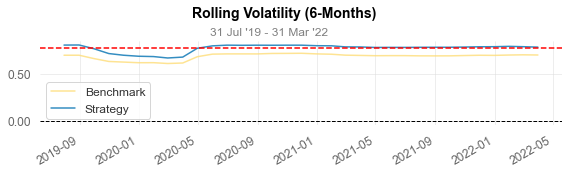

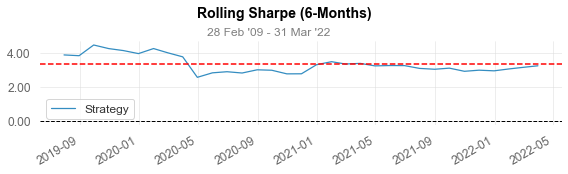

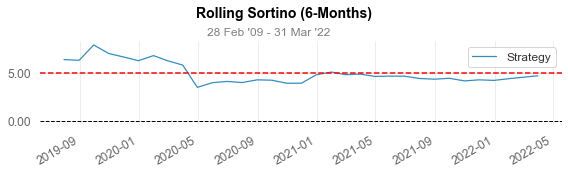

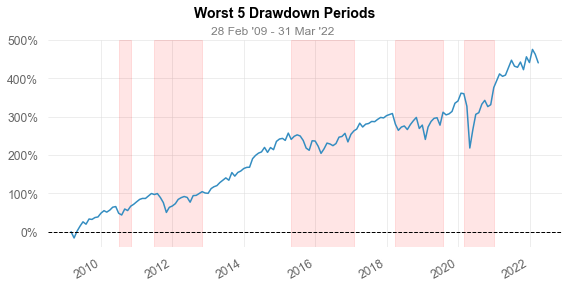

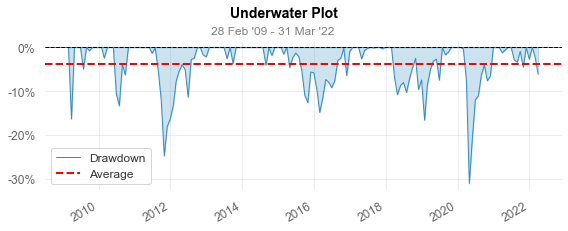

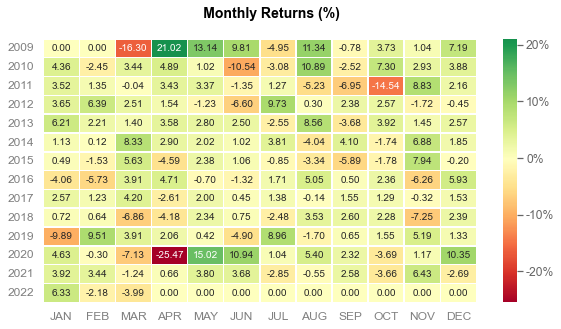

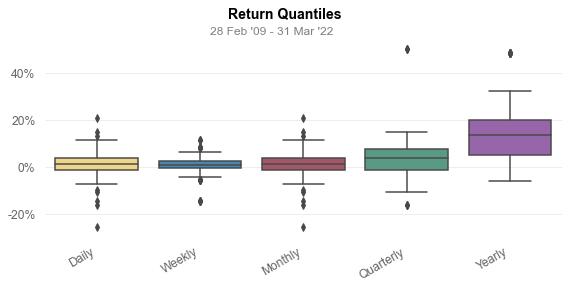

In [77]:
quantstats.reports.full(returns = rebal_strategy.loc[ : , 'strategy_return'],benchmark = rebal_strategy.loc[ :, 'benchmark_return'],)